# Titanic - Machine Learning from Disaster - Parte 5

- Vamos utilizar os [dados disponíveis no Kaggle](https://www.kaggle.com/competitions/titanic)
    - É um dataset de **competição**
    - O resultado é avaliado através da **acurácia**:
        - _"Sua pontuação é a porcentagem de passageiros que você prevê corretamente. Isso é conhecido como acurácia."_

### Importando novamente as bases e fazendo o tratamento dos dados

In [32]:
# Importando o pandas
import pandas as pd

In [33]:
# Visualizando a base de treino
treino = pd.read_csv('train.csv')
treino.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [34]:
# Visualizando a base de teste
teste = pd.read_csv('test.csv')
teste.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


- Fazendo o mesmo tratamento inicial que fizemos nas colunas vazias

In [35]:
# Eliminando as colunas com elevada cardinalidade
treino = treino.drop(['Name','Ticket','Cabin'],axis=1)
teste = teste.drop(['Name','Ticket','Cabin'],axis=1)

In [36]:
# Usando a média para substituir valores nulos na coluna de idade
treino.loc[treino.Age.isnull(),'Age'] = treino.Age.mean()
teste.loc[teste.Age.isnull(),'Age'] = teste.Age.mean()

In [37]:
# Tratando a coluna Embarked da base de treino usando a moda 
treino.loc[treino.Embarked.isnull(),'Embarked'] = treino.Embarked.mode()[0]

In [38]:
# E também a coluna Fare da base de teste usando a média
teste.loc[teste.Fare.isnull(),'Fare'] = teste.Fare.mean()

- E fazendo a engenharia de variáveis dos nossos dados

In [39]:
# Usando uma lambda function para tratar a coluna "Sex"
treino['MaleCheck'] = treino.Sex.apply(lambda x: 1 if x == 'male' else 0)
teste['MaleCheck'] = teste.Sex.apply(lambda x: 1 if x == 'male' else 0)

In [40]:
# Fazendo o RobustScaler das colunas Age e Fare
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(treino[['Age','Fare']])
treino[['Age','Fare']] = transformer.transform(treino[['Age','Fare']])

# e para a base de teste
transformer = RobustScaler().fit(teste[['Age','Fare']])
teste[['Age','Fare']] = transformer.transform(teste[['Age','Fare']])

In [41]:
# Adicionando a coluna sozinho
def sozinho(a,b):
    if (a == 0 and b == 0):
        return 1
    else:
        return 0
    
treino['Sozinho'] = treino.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)
teste['Sozinho'] = teste.apply(lambda x: sozinho(x.SibSp,x.Parch),axis=1)

In [42]:
# E criando a coluna de familiares
treino['Familiares'] = treino.SibSp + treino.Parch
teste['Familiares'] = treino.SibSp + treino.Parch

In [43]:
# Fazendo o OrdinalEncoder para a coluna Embarked
from sklearn.preprocessing import OrdinalEncoder
categorias = ['S','C','Q']

enc = OrdinalEncoder(categories=[categorias],dtype='int32')
enc = enc.fit(treino[['Embarked']])
treino['Embarked'] = enc.transform(treino[['Embarked']])

teste['Embarked'] = enc.transform(teste[['Embarked']])

In [44]:
# Apagando as colunas de texto
treino = treino.drop('Sex',axis=1)
teste = teste.drop('Sex',axis=1)

- Visualizando a base resultante

In [45]:
# Visualizando a base de treino
treino.head(3)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Sozinho,Familiares
0,1,0,3,-0.592240,1,0,-0.312011,0,1,0,1
1,2,1,1,0.638529,1,0,2.461242,1,0,0,1
2,3,1,3,-0.284548,0,0,-0.282777,0,0,1,0


### Utilizando outros modelos para fazer a previsão

In [46]:
# Importando o train_test_split
from sklearn.model_selection import train_test_split

In [47]:
# Separando a base de treino em X e y
X = treino.drop(['PassengerId','Survived'],axis=1)
y = treino.Survived

In [48]:
# Separando em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

- Para a **Regressão Logística**

In [49]:
# Importando
from sklearn.linear_model import LogisticRegression

In [50]:
# Criando o classificador
clf_rl = LogisticRegression(random_state=42)

In [51]:
# Definindo os parâmetros
parametros_rl = {
    'penalty': ['l1','l2'],
    'C': [0.01,0.1,1,10],
    'solver': ['lbfgs','liblinear','saga'],
    'max_iter': [100,1000,5000,10000]
}

- Para o **Random Forest**

In [52]:
# Importando
from sklearn.ensemble import RandomForestClassifier

In [53]:
# Criando o classificador
clf_rf = RandomForestClassifier(random_state=42)

In [54]:
# Definindo os parâmetros
parametros_rf = {
    'n_estimators': [100,200,500,1000],
    'criterion': ['gini','entropy','log_loss'],
    'max_depth': [2,4,6,8,None],
    'max_features': ['sqrt','log2',None]
}

- E para o **MLPClassifier (Redes Neurais)**

In [55]:
# Importando
from sklearn.neural_network import MLPClassifier

In [56]:
# Criando o classificador
clf_mlp = MLPClassifier(random_state=42)

In [57]:
# Definindo os parâmetros
parametros_mlp = {
    'solver':  ['lbfgs','sgd','adam'],
    'alpha': [10.0**(-1),10.0**(-5),10.0**(-7),10.0**(-10)],
    'max_iter': [200,500,1000,5000]
}

- **Fazendo o grid_search**

In [58]:
# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Importando o datetime para visualizar a hora atual
from datetime import datetime 
def hora_atual():
    agora = datetime.now()
    print(str(agora.hour)+':'+str(agora.minute)+":"+str(agora.second))

In [60]:
# Importando o KFold e o GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [61]:
# Para a Regressão Logística
hora_atual()
kfold_rl = KFold(shuffle=True,random_state=42,n_splits=8)
grid_search_rl = GridSearchCV(clf_rl, parametros_rl,scoring='accuracy',cv=kfold_rl)
grid_search_rl = grid_search_rl.fit(X_train,y_train)
hora_atual()

7:20:49


7:21:4


In [62]:
# Para o RandomForest
hora_atual()
kfold_rf = KFold(shuffle=True,random_state=42,n_splits=8)
grid_search_rf = GridSearchCV(clf_rf, parametros_rf,scoring='accuracy',cv=kfold_rf)
grid_search_rf = grid_search_rf.fit(X_train,y_train)
hora_atual()

7:21:4
7:51:25


In [63]:
# Para o MLPClassifier
hora_atual()
kfold_mlp = KFold(shuffle=True,random_state=42,n_splits=8)
grid_search_mlp = GridSearchCV(clf_mlp, parametros_mlp,scoring='accuracy',cv=kfold_mlp)
grid_search_mlp = grid_search_mlp.fit(X_train,y_train)
hora_atual()

7:51:25
8:1:58


- **Verificando os melhores scores**

In [64]:
# Verificando o melhor score da regressão logística
grid_search_rl.best_score_

0.8089887640449438

In [65]:
# Para o RandomForest
grid_search_rf.best_score_

0.8314606741573034

In [66]:
# e para o MLPClassifier
grid_search_mlp.best_score_

0.8174157303370786

- **E os melhores parâmetros**

In [67]:
# Verificando os melhores parâmetros da regressão logística
grid_search_rl.best_params_

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

In [68]:
# Para o RandomForest
grid_search_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [69]:
# e para o MLPClassifier
grid_search_mlp.best_params_

{'alpha': 0.1, 'max_iter': 200, 'solver': 'adam'}

- **Fazendo a previsão nos dados de validação com cada um dos melhores modelos**

In [70]:
# Para a regressão logística
clf_best_rl = grid_search_rl.best_estimator_
y_pred_rl = clf_best_rl.predict(X_val)

In [71]:
# Para o RandomForest
clf_best_rf = grid_search_rf.best_estimator_
y_pred_rf = clf_best_rf.predict(X_val)

In [72]:
# e para o MLPClassifier
clf_best_mlp = grid_search_mlp.best_estimator_
y_pred_mlp = clf_best_mlp.predict(X_val)

- **Avaliação dos modelos**
    - Acurácia (método de avaliação usado na competição):
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    - Matriz de confusão (ajuda a visualizar a distribuição dos erros):
        - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

- Avaliando a **acurácia**

In [73]:
# Importando
from sklearn.metrics import accuracy_score

In [74]:
# Para a Regressão Logística
accuracy_score(y_val, y_pred_rl)

0.8044692737430168

In [75]:
# Para o Random Forest
accuracy_score(y_val, y_pred_rf)

0.8100558659217877

In [76]:
# Para o MLPClassifier (Redes Neurais)
accuracy_score(y_val, y_pred_mlp)

0.8100558659217877

- Avaliando a **matriz de confusão**

In [77]:
# Importando
from sklearn.metrics import confusion_matrix

In [78]:
# Para a Regressão Logística
confusion_matrix(y_val, y_pred_rl)

array([[91, 14],
       [21, 53]], dtype=int64)

In [79]:
# Para o Random Forest
confusion_matrix(y_val, y_pred_rf)

array([[93, 12],
       [22, 52]], dtype=int64)

In [80]:
# Para o MLPClassifier (Redes Neurais)
confusion_matrix(y_val, y_pred_mlp)

array([[92, 13],
       [21, 53]], dtype=int64)

### Fazendo a previsão para os dados de teste
- Utilizando o modelo com melhor precisão para fazer o predict na base de teste

In [81]:
# Visualizando o X_train
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Sozinho,Familiares
331,1,1.215452,0,0,0.608317,0,1,1,0
733,2,-0.515317,0,0,-0.062981,0,1,1,0
382,3,0.176991,0,0,-0.282777,0,1,1,0


In [82]:
# Visualizando a base de teste
teste.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Sozinho,Familiares
0,892,3,0.331562,0,0,-0.280670,2,1,1,1
1,893,3,1.311954,1,0,-0.315800,0,0,0,1
2,894,2,2.488424,0,0,-0.201943,2,1,1,0


In [83]:
# Para a base de teste ser igual a base de treino, precisamos eliminar a coluna de id
X_teste = teste.drop('PassengerId',axis=1)

In [84]:
# Utilizando o melhor modelo na base de teste
y_pred = clf_best_rf.predict(X_teste)

In [85]:
# Criando uma nova coluna com a previsão na base de teste
teste['Survived'] = y_pred

In [86]:
# Selecionando apenas a coluna de Id e Survived para fazer o envio
base_envio = teste[['PassengerId','Survived']]

In [87]:
# Exportando para um csv
base_envio.to_csv('attempt5.csv',index=False)

### Score Público

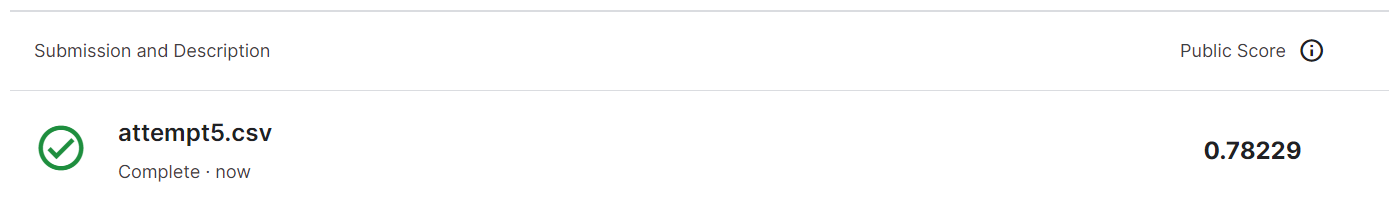

Resultado:
- 78% de acurácia nas previsões do 'attempt5', em relação a 69% de acurácia nas previsões do 'attempt4_mlp', sendo o melhor.

    - Critério de avaliação do modelo: acurácia

        - A terceira versão do sistema alcançou uma acurácia de 78% no score da competição de análise preditiva.
        - Pesquisa finalizada em 0.78229

- Foi utilizado o GridSearchCV para encontrar automaticamente os melhores parâmetros para o modelo RandomForest. Esse ajuste refinado levou a uma melhoria significativa no desempenho, com um score público no Kaggle de 0.78229